In [141]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import os
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [167]:
df = pd.read_csv('Data/banking_marketing_strategies.csv')
df.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,RevenueEarned,...,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,5281.88472,...,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,10963.48098,...,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,4585.36320,...,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,5280.25122,...,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,6596.40618,...,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


In [168]:
print("========== Missing Values ==========")
print(df.isnull().sum())

print("========== Duplicate Values ==========")
print(df.duplicated().sum())

========== Missing Values ==========
CustomerID             0
Age                    0
Gender                 0
Income                 0
CampaignChannel        0
CampaignType           0
AdSpend                0
ClickThroughRate       0
ConversionRate         0
RevenueEarned          0
WebsiteVisits          0
PagesPerVisit          0
TimeOnSite             0
SocialShares           0
EmailOpens             0
EmailClicks            0
PreviousPurchases      0
LoyaltyPoints          0
AdvertisingPlatform    0
AdvertisingTool        0
Conversion             0
dtype: int64
========== Duplicate Values ==========
0


In [22]:
print(df['CampaignChannel'].unique())
print(df['CampaignType'].unique())


['Social Media' 'Email' 'PPC' 'Referral' 'SEO']
['Awareness' 'Retention' 'Conversion' 'Consideration']


## Data Cleaning

Our personalised marketing efforts in this case involves 
1. Email and PPC for targeted ads
2. Social Media for brand awareness and customer engagement
3. Referral for acquiring customers through existing clients
4. SEO to improve search visibility and credibility

During our marketing campaign, we ran different campaign types to promote our product and services:
Awareness: When banks aim to introduce their services to potential customers, creating brand visibility.
Consideration: When potential customers start evaluating banking options, researching products and benefits.
Conversion: When customers are ready to act, applying for a product or opening an account.
Retention: When banks focus on keeping existing customers engaged and satisfied, fostering loyalty.

In [169]:
# dropping information redundant to our campaign which will help us calculate ROI
df.drop(
    columns=[
        'AdvertisingTool',
        'AdvertisingPlatform',
        'PagesPerVisit',
        'EmailOpens',
        'WebsiteVisits',
        'TimeOnSite',
        'SocialShares',
        'ClickThroughRate'],
    inplace=True
)

In [170]:
df.dtypes

CustomerID             int64
Age                    int64
Gender                object
Income                 int64
CampaignChannel       object
CampaignType          object
AdSpend              float64
ConversionRate       float64
RevenueEarned        float64
EmailClicks            int64
PreviousPurchases      int64
LoyaltyPoints          int64
Conversion             int64
dtype: object

In this case we decided to keep the relevant stages of conversion and retention, which are relevant for measuring and maximizing ROI of our marketing efforts

Conversion: This stage directly impacts ROI because it focuses on customer actions, such as applying for a product or opening an account. It is the most immediate driver of revenue and is essential for calculating the effectiveness of marketing spend in acquiring new customers.

Retention: Retaining customers can improve lifetime value, which is a crucial factor for maximizing ROI. Engaged and loyal customers are more likely to make additional purchases, use more services, or even refer new customers, thereby enhancing long-term revenue.

In [171]:
df_marketing = df[df['CampaignType'].isin(['Conversion', 'Retention'])]
df_marketing

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ConversionRate,RevenueEarned,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
1,8001,69,Male,41760,Email,Retention,3898.668606,0.182725,10963.48098,7,2,3459,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.088004,5280.25122,2,0,2463,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.109940,6596.40618,6,8,4345,1
7,8007,56,Female,57083,Social Media,Conversion,5324.283667,0.188946,11336.75550,3,0,2983,1
8,8008,36,Female,140788,Email,Retention,9421.250951,0.112585,6755.10066,8,5,460,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7989,15989,50,Female,84079,PPC,Retention,277.975579,0.183031,10981.84434,0,0,2935,0
7991,15991,62,Female,69289,SEO,Retention,6118.863881,0.047079,2824.75710,5,3,3075,1
7992,15992,37,Male,138422,Referral,Retention,2024.148848,0.068403,4104.17598,0,5,2733,0
7993,15993,20,Male,120271,Social Media,Retention,6973.120174,0.174582,10474.92798,1,7,3066,0


In [172]:
df_marketing.describe()

,CustomerID,Age,Income,AdSpend,ConversionRate,RevenueEarned,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,11984.893390,44.011680,84568.041750,4987.186666,0.104061,6243.670359,4.484841,4.530815,2480.162525,0.897117
std,2293.596494,14.822644,37395.411917,2846.222990,0.054973,3298.380578,2.856980,2.890158,1423.547374,0.303843
min,8001.000000,18.000000,20057.000000,103.956957,0.010020,601.193700,0.000000,0.000000,1.000000,0.000000
25%,9985.750000,32.000000,51917.000000,2472.063139,0.056163,3369.785655,2.000000,2.000000,1257.500000,1.000000
50%,12000.000000,44.000000,84526.500000,5039.892169,0.103603,6216.200370,4.000000,5.000000,2471.500000,1.000000
75%,13934.000000,57.000000,116432.750000,7432.776248,0.150915,9054.924960,7.000000,7.000000,3676.000000,1.000000
max,15996.000000,69.000000,149986.000000,9997.914781,0.199995,11999.682480,9.000000,9.000000,4999.000000,1.000000


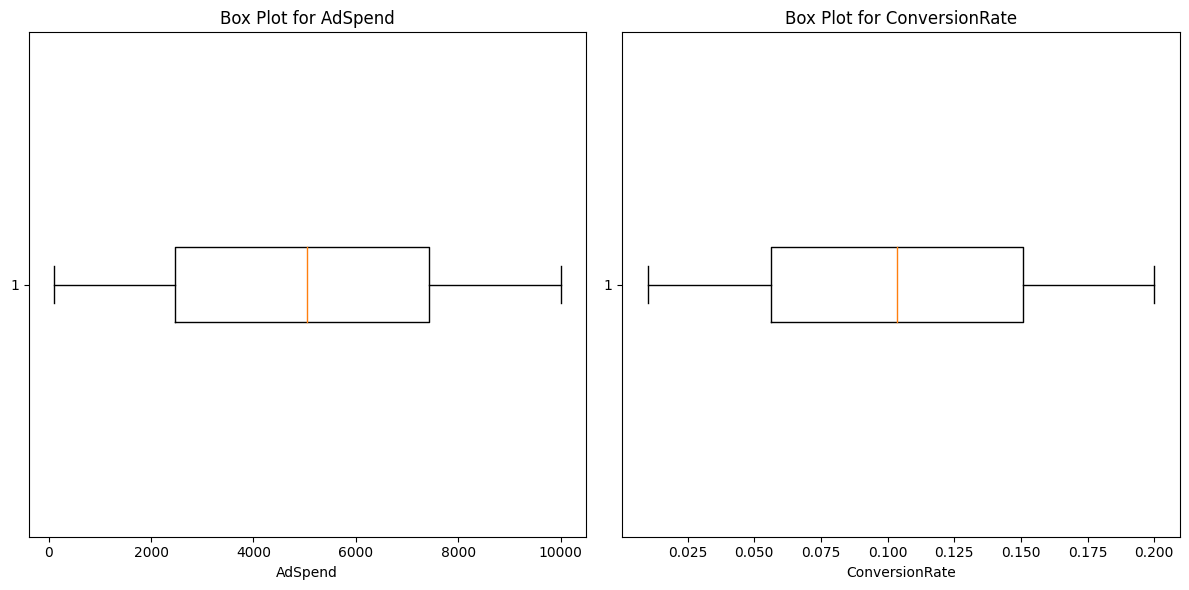

In [173]:
# Checking for outliers in the case of income, adspend and timeonesite
columns = ['AdSpend', 'ConversionRate']

# Set up the plot
plt.figure(figsize=(12, 6))

# Generate a box plot for each column
for i, column in enumerate(columns, 1):
    plt.subplot(1, len(columns), i)
    plt.boxplot(df_marketing[column].dropna(), vert=False)
    plt.title(f'Box Plot for {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()


The box plots reveal that AdSpend, Income, and TimeOnSite have well-distributed values with no outliers. This will help to ensure that the analysis of ROI for personalized marketing efforts reflects typical customer behavior and avoids misleading extremes. This help ensure that our model will have more reliable predictions later on, without the need for outlier handling.

## Feature Engineering step

Proceed to perform feature engineering to calculate
1. ROI (Return on Investment): we measure the profitability of our marketing efforts by comparing the revenue earned from each campaign to its cost.
We computed ROI as the difference between RevenueEarned and AdSpend, divided by AdSpend, which shows the return generated per dollar spent on advertising.

2. Customer Lifetime value: Total revenue a business can expect from a customer, adjusted by factors like loyalty points and conversion metrics. In this case, we calculated CLV with the focus on average revenue per conversion, multiplied by expected purchase frequency within a chosen period (e.g., a year). 

3. Conversion Rates: The likelihood of a customer engaging with a specific financial product or service, such as opening a new account or applying for a loan.

4. Campaign costs: Represented our by Ad spend across the different marketing strategies.

In [175]:

df_marketing['ROI'] = (df_marketing['RevenueEarned'] - df_marketing['AdSpend']) / df_marketing['AdSpend'] 

# Calculate CLV, assuming a standard period of 1 year
df_marketing['CLV'] = (df_marketing['RevenueEarned'].mean() + df_marketing['LoyaltyPoints']) * df_marketing['PreviousPurchases']

df_marketing

/var/folders/6b/dfh0f0ns21gdf75k1xqbfbpm0000gn/T/ipykernel_27737/3426453612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_marketing['ROI'] = (df_marketing['RevenueEarned'] - df_marketing['AdSpend']) / df_marketing['AdSpend']
/var/folders/6b/dfh0f0ns21gdf75k1xqbfbpm0000gn/T/ipykernel_27737/3426453612.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_marketing['CLV'] = (df_marketing['RevenueEarned'].mean() + df_marketing['LoyaltyPoints']) * df_marketing['PreviousPurchases']


,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ConversionRate,RevenueEarned,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion,ROI,CLV
1,8001,69,Male,41760,Email,Retention,3898.668606,0.182725,10963.48098,7,2,3459,1,1.812109,19405.340718
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.088004,5280.25122,2,0,2463,1,8.786835,0.000000
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.109940,6596.40618,6,8,4345,1,2.931010,84709.362871
7,8007,56,Female,57083,Social Media,Conversion,5324.283667,0.188946,11336.75550,3,0,2983,1,1.129255,0.000000
8,8008,36,Female,140788,Email,Retention,9421.250951,0.112585,6755.10066,8,5,460,1,-0.282993,33518.351794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7989,15989,50,Female,84079,PPC,Retention,277.975579,0.183031,10981.84434,0,0,2935,0,38.506508,0.000000
7991,15991,62,Female,69289,SEO,Retention,6118.863881,0.047079,2824.75710,5,3,3075,1,-0.538353,27956.011077
7992,15992,37,Male,138422,Referral,Retention,2024.148848,0.068403,4104.17598,0,5,2733,0,1.027606,44883.351794
7993,15993,20,Male,120271,Social Media,Retention,6973.120174,0.174582,10474.92798,1,7,3066,0,0.502187,65167.692512


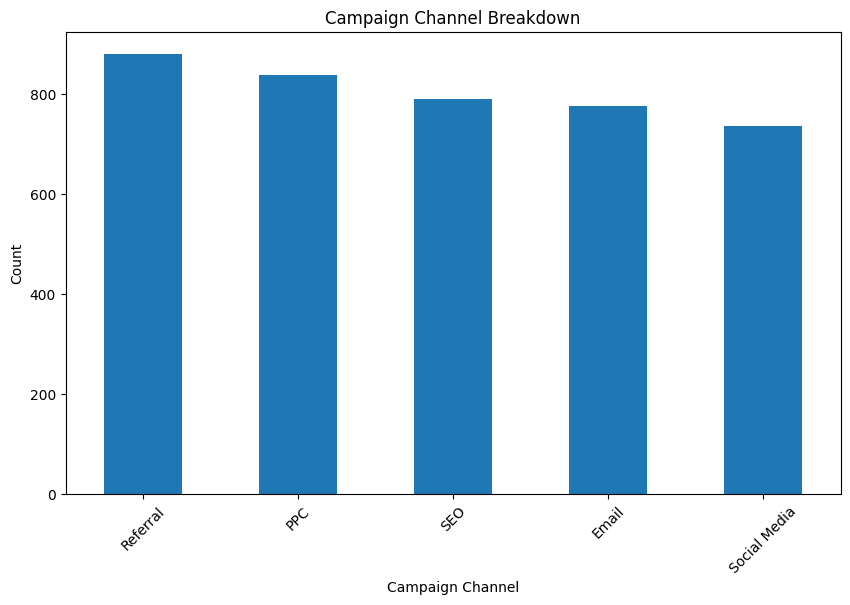

In [176]:
# Assuming df_marketing is defined and has a 'CampaignChannel' column
campaign_counts = df_marketing['CampaignChannel'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
campaign_counts.plot(kind='bar')
plt.title("Campaign Channel Breakdown")
plt.xlabel("Campaign Channel")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Label encoding for non-numerical columns

In [177]:
# Initialize label encoders
gender_encoder = LabelEncoder()
campaign_type_encoder = LabelEncoder()


# Dropping the CustomerID
df_marketing = df_marketing.drop(columns=['CustomerID'])


# Apply label encoding 
df_marketing.loc[:,'Gender'] = gender_encoder.fit_transform(df_marketing['Gender'])
df_marketing.loc[:,'CampaignType'] = campaign_type_encoder.fit_transform(df_marketing['CampaignType'])


df_marketing

,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ConversionRate,RevenueEarned,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion,ROI,CLV
1,69,1,41760,Email,1,3898.668606,0.182725,10963.48098,7,2,3459,1,1.812109,19405.340718
3,32,0,44085,PPC,0,539.525936,0.088004,5280.25122,2,0,2463,1,8.786835,0.000000
4,60,0,83964,PPC,0,1678.043573,0.109940,6596.40618,6,8,4345,1,2.931010,84709.362871
7,56,0,57083,Social Media,0,5324.283667,0.188946,11336.75550,3,0,2983,1,1.129255,0.000000
8,36,0,140788,Email,1,9421.250951,0.112585,6755.10066,8,5,460,1,-0.282993,33518.351794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7989,50,0,84079,PPC,1,277.975579,0.183031,10981.84434,0,0,2935,0,38.506508,0.000000
7991,62,0,69289,SEO,1,6118.863881,0.047079,2824.75710,5,3,3075,1,-0.538353,27956.011077
7992,37,1,138422,Referral,1,2024.148848,0.068403,4104.17598,0,5,2733,0,1.027606,44883.351794
7993,20,1,120271,Social Media,1,6973.120174,0.174582,10474.92798,1,7,3066,0,0.502187,65167.692512


Feature selection using random forest regressor

Reduce dimensions, overfitting rsik and also avoid more multicollinearity issues across the different features

In [178]:
X = df_marketing.drop(columns=['ROI', 'CampaignChannel'])  # Features
y = df_marketing['ROI']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Calculate and sort feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

print("Feature importances (sorted):")
print(feature_importances_sorted)

# Ensure the 'Models' directory exists
if not os.path.exists('Models'):
    os.makedirs('Models')

# Save the model as a pickle file
with open('Models/random_forest_model_overall.pkl', 'wb') as f:
    pickle.dump(rf, f)


Feature importances (sorted):
AdSpend              0.740448
ConversionRate       0.120376
RevenueEarned        0.117896
Income               0.008714
LoyaltyPoints        0.002882
CLV                  0.002545
Age                  0.002309
EmailClicks          0.001793
PreviousPurchases    0.001578
Conversion           0.000747
Gender               0.000464
CampaignType         0.000247
dtype: float64


Campaign cost in this case is the greatest contributor to how effective our campaign is, followed by the revenue and conversionr rate.

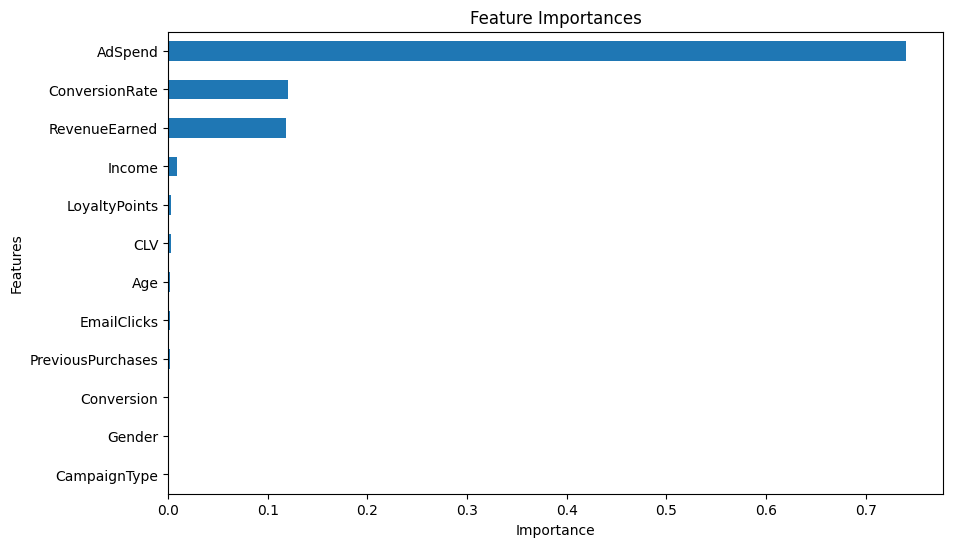

In [179]:
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

Post Feature selection, we will begin training the model for each of our 5 marketing strategies to predict the ROI and performance.

Training a few model according to the cleaned data and using a threshold of 0.8 for model training

## Linear Regression

Starting off with simpler models

In [184]:
# Ensure the 'Models' directory exists
if not os.path.exists('Models'):
    os.makedirs('Models')

# Get the top 7 features so that we have CLV Inclusive
top_features = feature_importances.nlargest(6).index

marketing_strategies = df_marketing['CampaignChannel'].unique().tolist()

# Conduct analysis for each marketing strategy
for strategy in marketing_strategies:
    print(f"========== {strategy} ==========")

    # Filter dataset for the current strategy
    X_strategy = df_marketing[df_marketing['CampaignChannel'] == strategy]
    Y_strategy = X_strategy['ROI']
    X_strategy = X_strategy.drop(columns=['ROI', 'CampaignChannel'])
    X_strategy = X_strategy[top_features]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_strategy, Y_strategy, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Display results
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R2 Score: {r2}")
    print(f'ROI Mean: {Y_strategy.mean()}')
    print()

    # Save the model
    model_filename = f"Models/linear_regression_model_{strategy}.pkl"
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)


========== Email ==========
Mean Absolute Error (MAE): 1.928501377251866
Root Mean Squared Error (RMSE): 3.7449533369401196
R2 Score: 0.34396825542186926
ROI Mean: 1.4581831090204065

========== PPC ==========
Mean Absolute Error (MAE): 2.19799960613266
Root Mean Squared Error (RMSE): 3.024063159478902
R2 Score: 0.3348186129269032
ROI Mean: 1.8895801537151282

========== Social Media ==========
Mean Absolute Error (MAE): 2.8435981290120464
Root Mean Squared Error (RMSE): 4.9261449660187395
R2 Score: 0.26897963935749114
ROI Mean: 2.197154708747066

========== Referral ==========
Mean Absolute Error (MAE): 2.522806632905653
Root Mean Squared Error (RMSE): 5.6014654674540205
R2 Score: 0.2840844193166666
ROI Mean: 1.8996245008144463

========== SEO ==========
Mean Absolute Error (MAE): 2.598246189796245
Root Mean Squared Error (RMSE): 4.6846456542940755
R2 Score: 0.36753091739071264
ROI Mean: 1.9732796784077806



## Randomforest Regressor

In [187]:
# Randomized Search CV to get the best given parameters that will return the best results
def rf_best_params(X_train, y_train):
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    return best_params


In [188]:
# Ensure the 'Models' directory exists
if not os.path.exists('Models'):
    os.makedirs('Models')

# Get the unique strategies
marketing_strategies = df_marketing['CampaignChannel'].unique().tolist()

# Conduct analysis for each strategy
for strategy in marketing_strategies:
    print(f"========== {strategy} ==========")

    # Filter dataset for the current strategy
    X_strategy = df_marketing[df_marketing['CampaignChannel'] == strategy]
    Y_strategy = X_strategy['ROI']
    X_strategy = X_strategy.drop(columns=['ROI', 'CampaignChannel'])
    X_strategy = X_strategy[top_features]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_strategy, Y_strategy, test_size=0.2, random_state=42)

    # Get the best parameters for RandomForestRegressor
    best_params = rf_best_params(X_train, y_train)

    # Train the model
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Display results
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R2 Score: {r2}")
    print(f'ROI Mean: {Y_strategy.mean()}')
    print()

    # Save the model
    model_filename = f"Models/random_forest_model_{strategy}.pkl"
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    


========== Email ==========
Mean Absolute Error (MAE): 0.45185769964752937
Root Mean Squared Error (RMSE): 1.4072322670525463
R2 Score: 0.9073674535351277
ROI Mean: 1.4581831090204065

========== PPC ==========
Mean Absolute Error (MAE): 0.11748811597301108
Root Mean Squared Error (RMSE): 0.33436472968141134
R2 Score: 0.9918679639888045
ROI Mean: 1.8895801537151282

========== Social Media ==========
Mean Absolute Error (MAE): 0.5057212765752537
Root Mean Squared Error (RMSE): 2.09831215580938
R2 Score: 0.867365870841956
ROI Mean: 2.197154708747066

========== Referral ==========
Mean Absolute Error (MAE): 0.6805223300659758
Root Mean Squared Error (RMSE): 3.1377140936498575
R2 Score: 0.7753609647925527
ROI Mean: 1.8996245008144463

========== SEO ==========
Mean Absolute Error (MAE): 0.7735124193988132
Root Mean Squared Error (RMSE): 3.2682350335040096
R2 Score: 0.6921689883737672
ROI Mean: 1.9732796784077806



## Gradient Boosting Regressor

By comparing different model,  gradient boosting regressor seems the most effective and we will use it as our main model for predicting the ROI

In [186]:
# Ensure the 'Models' directory exists
if not os.path.exists('Models'):
    os.makedirs('Models')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5]
}

# Get the unique strategies
marketing_strategies = df_marketing['CampaignChannel'].unique().tolist()

# Conduct analysis for each strategy
for strategy in marketing_strategies:
    print(f"========== {strategy} ==========")

    # Filter dataset for the current strategy
    X_strategy = df_marketing[df_marketing['CampaignChannel'] == strategy]
    Y_strategy = X_strategy['ROI']
    X_strategy = X_strategy.drop(columns=['ROI', 'CampaignChannel'])
    X_strategy = X_strategy[top_features]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_strategy, Y_strategy, test_size=0.2, random_state=42)

    # Initialize the model
    model = GradientBoostingRegressor(random_state=42)

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    

    # Train the model with the best parameters
    model = GradientBoostingRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Display results
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R2 Score: {r2}")
    print(f'ROI Mean: {Y_strategy.mean()}')
    print()

    # Save the model
    model_filename = f"Models/gradient_boosting_model_{strategy}.pkl"
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    


========== Email ==========
Mean Absolute Error (MAE): 0.31268860090302153
Root Mean Squared Error (RMSE): 1.4221425334994646
R2 Score: 0.9053940862724419
ROI Mean: 1.4581831090204065

========== PPC ==========
Mean Absolute Error (MAE): 0.21385384718764494
Root Mean Squared Error (RMSE): 0.41661034815248815
R2 Score: 0.9873753752014706
ROI Mean: 1.8895801537151282

========== Social Media ==========
Mean Absolute Error (MAE): 0.5362230632026911
Root Mean Squared Error (RMSE): 2.3641538972798477
R2 Score: 0.831629273752391
ROI Mean: 2.197154708747066

========== Referral ==========
Mean Absolute Error (MAE): 0.3482943539259077
Root Mean Squared Error (RMSE): 0.9772934201144331
R2 Score: 0.9782074305901244
ROI Mean: 1.8996245008144463

========== SEO ==========
Mean Absolute Error (MAE): 0.5116402860347758
Root Mean Squared Error (RMSE): 1.9152226016403462
R2 Score: 0.8942879916199918
ROI Mean: 1.9732796784077806

